## GTFS Static Load

GTFS static schedule data will have to be loaded in a way that historical data is preserved. 

`convert_gtfs.py` currently creates `timestamp` field on all tables converted to parquet. 

Logic possibly needed to perform historical matches between gtfs and gtfs-rt datasets. 

In [2]:
# IMPORTS

import numpy as np
import pandas as pd
import boto3
import time
import pathlib
import pickle
import io
from typing import IO
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO)

Load GTFS static (schedule) data from txt files, this will be done from RDS or direct parquet file read in future. 

In [3]:
trips = pd.read_csv('./gtfs/trips.txt', low_memory=False)
routes = pd.read_csv('./gtfs/routes.txt', low_memory=False)
gtfs_stops = pd.read_csv('./gtfs/stops.txt', low_memory=False)
stop_times = pd.read_csv('./gtfs/stop_times.txt', low_memory=False, parse_dates=['arrival_time','departure_time'])
calendar = pd.read_csv('./gtfs/calendar.txt', low_memory=False)
feed_info = pd.read_csv('./gtfs/feed_info.txt', low_memory=False)

Create stop_id lookup table. Converts all stop_id's into 'parent_station' values. 'parent_station' comes from gtfs 'stops' table. 'parent_station' is used for every stop_id with a 'parent_station' value. Otherwise the stop_id is assumed to be a parent station. 

In [4]:
stop_id_lookup = gtfs_stops.loc[:,['stop_id','parent_station']]
mask = stop_id_lookup.parent_station.isna()
stop_id_lookup.loc[mask, 'parent_station'] = stop_id_lookup.loc[mask,'stop_id']

Calculate expected headways from GTFS static data.

Requires joining of stop_times with routes, trips, stop_id_lookup and calendar tables. 

In [5]:
'''
Drop un-used columns from stop_times
'''
stop_times_drop_columns = [
    'stop_headsign',
    'continuous_pickup',
    'continuous_drop_off'
]
gtfs_headways = stop_times.drop(columns=stop_times_drop_columns)

'''
Merge tables 
'''
t_trips = trips.merge(routes.loc[:,['route_id','route_type']], how='left', on=['route_id'])
gtfs_headways = gtfs_headways.merge(t_trips.loc[:,['trip_id','route_type','route_id','service_id','direction_id']], how='left', on=['trip_id'])
gtfs_headways = gtfs_headways.merge(stop_id_lookup.loc[:,:], how='left', on=['stop_id'])
gtfs_headways = gtfs_headways.merge(calendar.loc[:,['service_id','thursday']], how='left',on=['service_id'])

"""
limit headways to subway lines (route_type less than 2)
"""
sub_gtfs_headways = gtfs_headways.loc[(gtfs_headways.route_type < 2),:]


"""
Function to convert departure_time to all seconds departure_time_sec
"""
def time_to_seconds(time:str) -> int:
    (hour, min, sec) = time.split(":")
    return int(hour) * 3600 + int(min) * 60 + int(sec)
sub_gtfs_headways = sub_gtfs_headways.assign(departure_time_sec=sub_gtfs_headways['departure_time'].apply(time_to_seconds))
# sub_gtfs_headways['departure_time_sec'] = sub_gtfs_headways.loc[:,'departure_time'].apply(time_to_seconds)

"""
Sort stop_times to group data of same lines for headways calculation
"""
sub_gtfs_headways = sub_gtfs_headways.sort_values(by=['direction_id','route_id','service_id','parent_station','departure_time_sec'])

"""
Calculate previous stop departure time with shift on sorted data.
"""
sub_gtfs_headways = sub_gtfs_headways.assign(prev_departure_time_sec = sub_gtfs_headways['departure_time_sec'].shift().where(sub_gtfs_headways.parent_station.eq(sub_gtfs_headways.parent_station.shift())).astype('int', errors='ignore'))

"""
Where prev_departure_time_sec is NA, shift occured between different stations, so head_way calculation would not be valid.
Drop these rows
Essentially first stop of each route/service combination
"""
sub_gtfs_headways.dropna(axis=0, subset=['prev_departure_time_sec'], inplace=True)

"""
Calculate headway as departure_time_sec - prev_departure_time_sec
"""
sub_gtfs_headways = sub_gtfs_headways.assign(head_way = sub_gtfs_headways['departure_time_sec'] - sub_gtfs_headways['prev_departure_time_sec'])

sub_gtfs_headways

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,timepoint,checkpoint_id,route_type,route_id,service_id,direction_id,parent_station,thursday,departure_time_sec,prev_departure_time_sec,head_way
984140,52451939,05:35:00,05:35:00,70047,7,0,0,0.0,aport,1,Blue,RTL322-3-Sa-01,0,place-aport,1,20100,19020.0,1080.0
984152,52451940,05:42:00,05:42:00,70047,7,0,0,0.0,aport,1,Blue,RTL322-3-Sa-01,0,place-aport,1,20520,20100.0,420.0
984164,52451941,05:50:00,05:50:00,70047,7,0,0,0.0,aport,1,Blue,RTL322-3-Sa-01,0,place-aport,1,21000,20520.0,480.0
984176,52451942,05:57:00,05:57:00,70047,7,0,0,0.0,aport,1,Blue,RTL322-3-Sa-01,0,place-aport,1,21420,21000.0,420.0
984188,52451943,06:05:00,06:05:00,70047,7,0,0,0.0,aport,1,Blue,RTL322-3-Sa-01,0,place-aport,1,21900,21420.0,480.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954958,52371133,23:25:00,23:25:00,70100,4,0,0,0.0,wlsta,1,Red,RTL322-9-Sa-01,1,place-wlsta,1,84300,83400.0,900.0
954976,52371134,23:40:00,23:40:00,70100,4,0,0,0.0,wlsta,1,Red,RTL322-9-Sa-01,1,place-wlsta,1,85200,84300.0,900.0
954994,52371135,23:55:00,23:55:00,70100,4,0,0,0.0,wlsta,1,Red,RTL322-9-Sa-01,1,place-wlsta,1,86100,85200.0,900.0
955012,52371136,24:10:00,24:10:00,70100,4,0,0,0.0,wlsta,1,Red,RTL322-9-Sa-01,1,place-wlsta,1,87000,86100.0,900.0


Query S3 springboard bucket to get list of RT_VEHICLE_POSITIONS parquet files. This will not be a long term workflow, just temporary for development purposes. 

Save list of files as pickle file, if does not already exist (also temporary).

In [6]:
BUCKET_NAME = 'mbta-ctd-dataplatform-dev-springboard'
FILE_LIST_FILE = pathlib.Path('gtfs_rt_vehicle_pos')
PREFIX = 'lamp/RT_VEHICLE_POSITIONS/year=2022/month=7/day='

s3 = boto3.resource('s3')

bucket = s3.Bucket(BUCKET_NAME)
client = bucket.meta.client

t0 = time.monotonic()

if FILE_LIST_FILE.is_file():
    with open(FILE_LIST_FILE, mode='rb') as f:
        obj_list = pickle.load(f)

else:
    obj_list = []
    for prefix in ('20','21','22',):
        paginator = client.get_paginator('list_objects_v2')
        pages = paginator.paginate(
            Bucket=BUCKET_NAME,
            Prefix=f'{PREFIX}{prefix}/',
        )
        for page in pages:
            for obj in page['Contents']:
                if obj['Size'] > 0:
                    obj_list.append(obj)
    with open(FILE_LIST_FILE, mode='wb') as f:
        pickle.dump(obj_list, f)

run_time = time.monotonic() - t0

logging.info(f"{len(obj_list):,} files found in {run_time:.2f} seconds")

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:root:129 files found in 0.00 seconds


Using list of parquet files, download each file, convert to dataframe and concat with other files. Some columns that are currently not needed are also dropped to improve size of data in memmory. 

In [7]:
'''
Function for downloading parquet files, taken from py_gtfs_rt_ingestion
'''
def get_zip_buffer(filename: str) -> IO[bytes]:
    """
    Get a buffer for a zip file from s3 so that it can be read by zipfile
    module. filename is assumed to be the full path to the zip file without the
    s3:// prefix. Return it along with the last modified date for this s3
    object.
    """
    # inspired by
    # https://betterprogramming.pub/unzip-and-gzip-incoming-s3-files-with-aws-lambda-f7bccf0099c9
    (bucket, file) = filename.split("/", 1)
    s3_resource = boto3.resource("s3")
    zipped_file = s3_resource.Object(bucket_name=bucket, key=file)

    return io.BytesIO(zipped_file.get()["Body"].read())

'''
Columns to drop, decrease size of data in memmory, increase processign speed?
'''
drop_columns = [
    'occupancy_percentage',
    'occupancy_status',
    'vehicle_id', # always same as 'entity_id'
    'vehicle_consist',
    'bearing',
    'latitude',
    'longitude',
    'trip_id', # Always None?
]
'''
Limit RT data to subway route_id's temporary step for this process.
reduce size of data in memmory
'''
sub_route_ids = sub_gtfs_headways.route_id.unique()


raw_gtfs_rt = None
for obj in obj_list:
    filename = f"{BUCKET_NAME}/{obj['Key']}"
    logging.info(f"Downloading: {filename}")
    t_df = pd.read_parquet(get_zip_buffer(filename))
    
    # Drop columns not being used
    t_df = t_df.drop(columns=drop_columns)
    # Limit to subway RT daya
    t_df = t_df.loc[(t_df.route_id.isin(sub_route_ids)),:]

    if raw_gtfs_rt is None:
        raw_gtfs_rt = t_df
    else:
        raw_gtfs_rt = pd.concat([raw_gtfs_rt,t_df])
    logging.info(f"Processed: {filename}")

# raw_gtfs_rt

INFO:root:Downloading: mbta-ctd-dataplatform-dev-springboard/lamp/RT_VEHICLE_POSITIONS/year=2022/month=7/day=20/hour=0/ade29e12f6144ebdaa27c86083a358b3-0.parquet
INFO:root:Processed: mbta-ctd-dataplatform-dev-springboard/lamp/RT_VEHICLE_POSITIONS/year=2022/month=7/day=20/hour=0/ade29e12f6144ebdaa27c86083a358b3-0.parquet
INFO:root:Downloading: mbta-ctd-dataplatform-dev-springboard/lamp/RT_VEHICLE_POSITIONS/year=2022/month=7/day=20/hour=0/eecaaf159f804e9686f4d16f816a708f-0.parquet
INFO:root:Processed: mbta-ctd-dataplatform-dev-springboard/lamp/RT_VEHICLE_POSITIONS/year=2022/month=7/day=20/hour=0/eecaaf159f804e9686f4d16f816a708f-0.parquet
INFO:root:Downloading: mbta-ctd-dataplatform-dev-springboard/lamp/RT_VEHICLE_POSITIONS/year=2022/month=7/day=20/hour=1/2e14b3724450454d8bd2578e63995dae-0.parquet
INFO:root:Processed: mbta-ctd-dataplatform-dev-springboard/lamp/RT_VEHICLE_POSITIONS/year=2022/month=7/day=20/hour=1/2e14b3724450454d8bd2578e63995dae-0.parquet
INFO:root:Downloading: mbta-ctd-da

Calculated expected next stop for schedule data.

This is an initial attempt at identifying missed stops in RT data, but does not seem like a good approach.

In [8]:
next_stop = sub_gtfs_headways.sort_values(
                by=['trip_id','departure_time_sec']
            )[['direction_id','trip_id','parent_station','route_id']]

next_stop = next_stop.assign(
                next_trip_id = next_stop['trip_id'].shift(-1),
                expect_next_parent_station = next_stop['parent_station'].shift(-1)
)

next_stop = next_stop[
                (~next_stop['expect_next_parent_station'].isna()) 
                & (next_stop['route_id'] == next_stop['route_id'])
            ]

next_stop = next_stop.groupby(
                by=['route_id','direction_id','parent_station']
            )['expect_next_parent_station'].apply(lambda x: '|'.join(x.unique())).reset_index()

# next_stop

Another approach for identifying missed stops.

There are issues with ordering missed stops by either vehicle_timestamp_min or vehicle_timestamp_max, producing mixed results. Seems to be a GTFS-RT problem. 

Using vehicle_timestamp_max seems to produce the smallest number of missed stop %, but still records some false positives on missed stops because of incorrect record ordering. 

In [9]:
missed_stops = raw_gtfs_rt.copy()
'''
If current_status is not 'STOPPED_AT' change to 'MOVING'
'''
missed_stops.loc[missed_stops['current_status'] != 'STOPPED_AT','current_status'] = 'MOVING'

'''
Add parent_station to RT data
'''
missed_stops = missed_stops.merge(stop_id_lookup, how='left', on=['stop_id'])

'''
Create pivot table on max and min vehicle_timestamp.
This will combine all records for "MOVING" and "STOPPED_AT" for each vehicle and stataion into one row of data.
'''
group_by_cols = [
    # 'entity_id',
    'current_status',
    'current_stop_sequence',
    'parent_station',
    'direction_id',
    'route_id',
    'schedule_relationship',
    'start_date',
    'start_time',
    'vehicle_label', # vehicle label vs entity_id? for RT???
    ]
aggfunc = {
    'vehicle_timestamp':['max','min']
    }
missed_stops = missed_stops.pivot_table(
        missed_stops, 
        index=group_by_cols, 
        aggfunc=aggfunc
    ).reset_index()

'''
Fix column names after pivot_table created multi-index.
'''
missed_stops.columns = [col[0] if col[1] == '' else '_'.join(col).strip() for col in missed_stops.columns.values]
# missed_stops = missed_stops.assign(
#     vehicle_timestamp_avg = (missed_stops['vehicle_timestamp_min']+missed_stops['vehicle_timestamp_max'])/2,
# )
# missed_stops = missed_stops.sort_values(by=['entity_id','vehicle_timestamp_avg'])
# missed_stops = missed_stops.sort_values(by=['vehicle_label','vehicle_timestamp_avg'])
missed_stops = missed_stops.sort_values(by=['vehicle_label','vehicle_timestamp_max'])
# missed_stops = missed_stops.sort_values(by=['vehicle_label','vehicle_timestamp_min'])

missed_stops = missed_stops.assign(
    missed_stop = np.nan,
    stop_vehicle_label = missed_stops['vehicle_label'].shift(-1),
    # stop_entity_id = missed_stops['entity_id'].shift(-1),
    stop_start_time = missed_stops['start_time'].shift(-1),
    stop_parent_station = missed_stops['parent_station'].shift(-1),
    stop_direction_id = missed_stops['direction_id'].shift(-1),
    # stop_vehicle_timestamp_avg = missed_stops['vehicle_timestamp_avg'].shift(-1),
    stop_vehicle_timestamp_max = missed_stops['vehicle_timestamp_max'].shift(-1),
    # stop_vehicle_timestamp_min = missed_stops['vehicle_timestamp_min'].shift(-1),
)

missed_stops.loc[
    (missed_stops['current_status'] == 'MOVING')
    # &(missed_stops['vehicle_timestamp_avg'] < missed_stops['stop_vehicle_timestamp_avg'])
    &(missed_stops['vehicle_timestamp_max'] < missed_stops['stop_vehicle_timestamp_max'])
    # &(missed_stops['vehicle_timestamp_min'] < missed_stops['stop_vehicle_timestamp_min'])
    &(missed_stops['vehicle_label'] == missed_stops['stop_vehicle_label'])
    # &(missed_stops['entity_id'] == missed_stops['stop_entity_id'])
    &(missed_stops['start_time'] == missed_stops['stop_start_time'])
    &(missed_stops['direction_id'] == missed_stops['stop_direction_id'])
    &(missed_stops['parent_station'] != missed_stops['stop_parent_station'])
    ,'missed_stop'] = 'y'

missed_stop_count = missed_stops[(missed_stops['missed_stop']=='y')].shape[0]
recorded_stop_count = missed_stops[(missed_stops['current_status']=='STOPPED_AT')].shape[0]
missed_stop_pct = missed_stop_count / (missed_stop_count+recorded_stop_count) * 100
logging.info(f"Missed stop %: {missed_stop_pct:.2f}")

# missed_stops.to_csv('missed_stops.csv', index=False)

INFO:root:Missed stop %: 0.33


Produce realtime headways calculations without missed stops adjustemnts.

In [10]:
'''
Get only STOPPED_AT gtfs-rt records
'''
rt_headways = raw_gtfs_rt.loc[(raw_gtfs_rt['current_status'] == 'STOPPED_AT'), :]

'''
Merge parent_station
'''
rt_headways = rt_headways.merge(
        stop_id_lookup, 
        how='left', 
        on=['stop_id']
    )

'''
Group by unique records and vehicle_timestamp min/max
'''
group_by_cols = [
        'entity_id',
        'current_status',
        'current_stop_sequence',
        'parent_station',
        'direction_id',
        'route_id',
        'schedule_relationship',
        'start_date',
        'start_time',
        'vehicle_label'
    ]
aggfunc = {'vehicle_timestamp':['min','max']}
rt_headways = pd.pivot_table(
        rt_headways, 
        index=group_by_cols, 
        aggfunc=aggfunc
    ).reset_index()

'''
Fix column names after pivot_table created multi-index.
'''
rt_headways.columns = [col[0] if col[1] == '' else '_'.join(col).strip() for col in rt_headways.columns.values]

'''
Sort table for shift operation
'''
rt_headways = rt_headways.sort_values(
    by=[
        'direction_id',
        'start_date',
        'route_id',
        'parent_station',
        'vehicle_timestamp_min'
        ]
)

rt_headways = rt_headways.assign(
    prev_arrive_time_sec = rt_headways['vehicle_timestamp_min'].shift().where(rt_headways.parent_station.eq(rt_headways.parent_station.shift())).astype('int', errors='ignore')
)

rt_headways = rt_headways.dropna(axis=0, subset=['prev_arrive_time_sec'])

rt_headways = rt_headways.assign(
    head_way = rt_headways['vehicle_timestamp_min'] - rt_headways['prev_arrive_time_sec'],
    dt = pd.to_datetime(rt_headways['vehicle_timestamp_min'], unit='s')
)

# rt_headways

Charting for demonstration purposes

<ipython-input-11-fa9bbc28ac0c>:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(20,8))


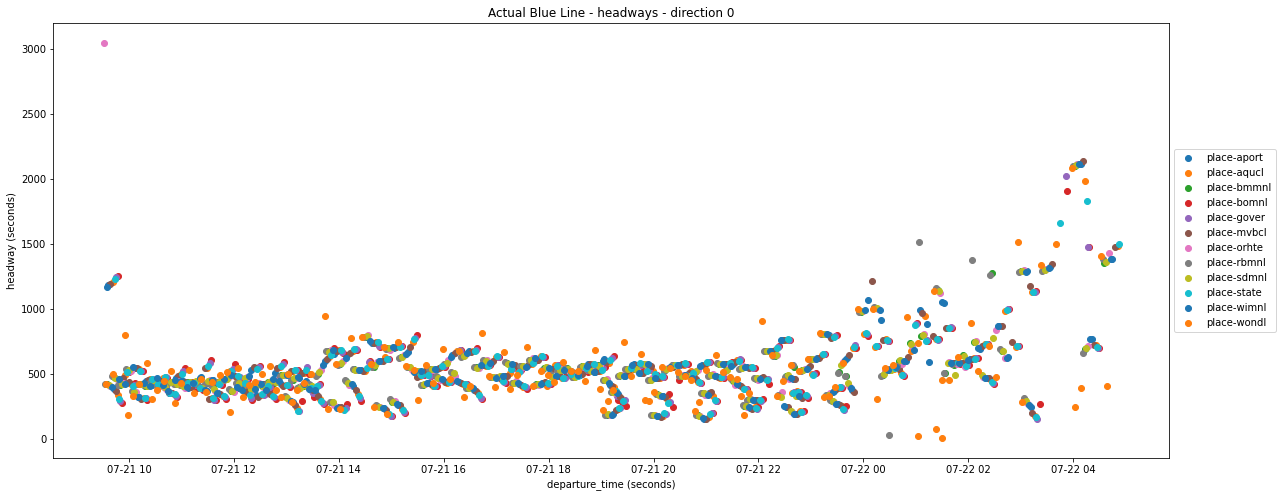

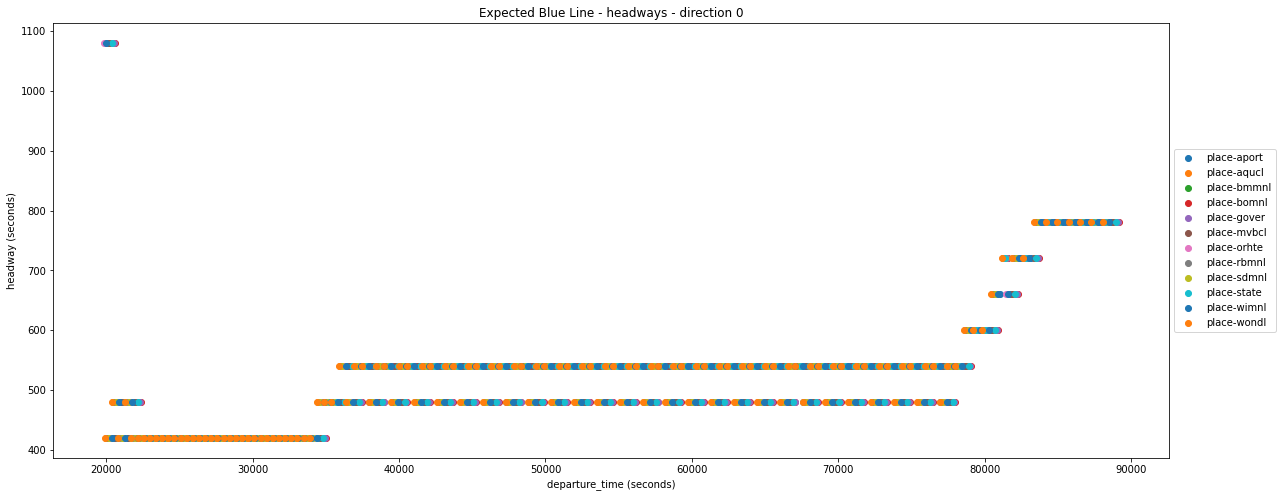

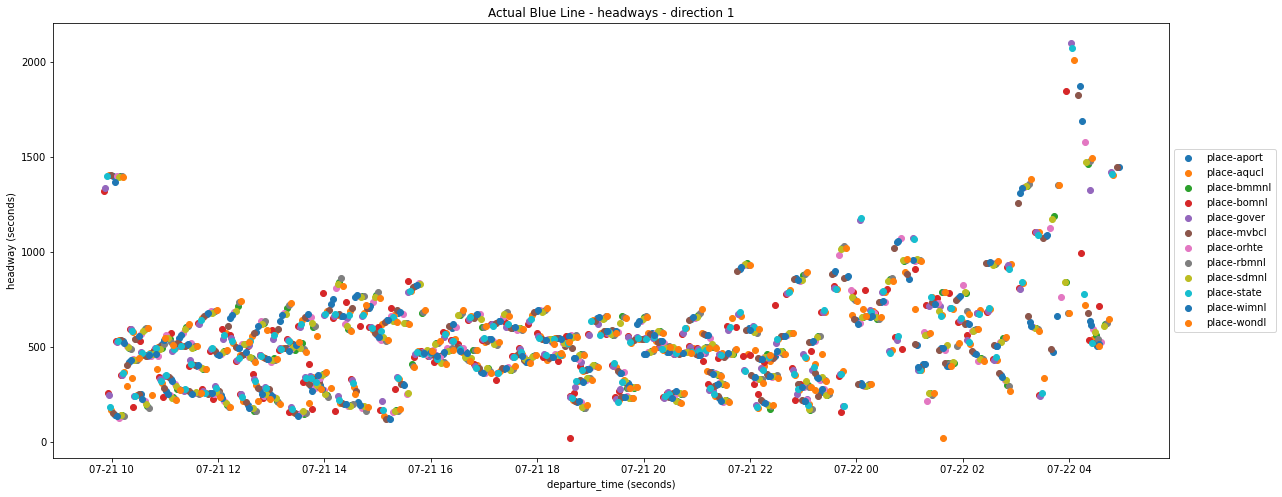

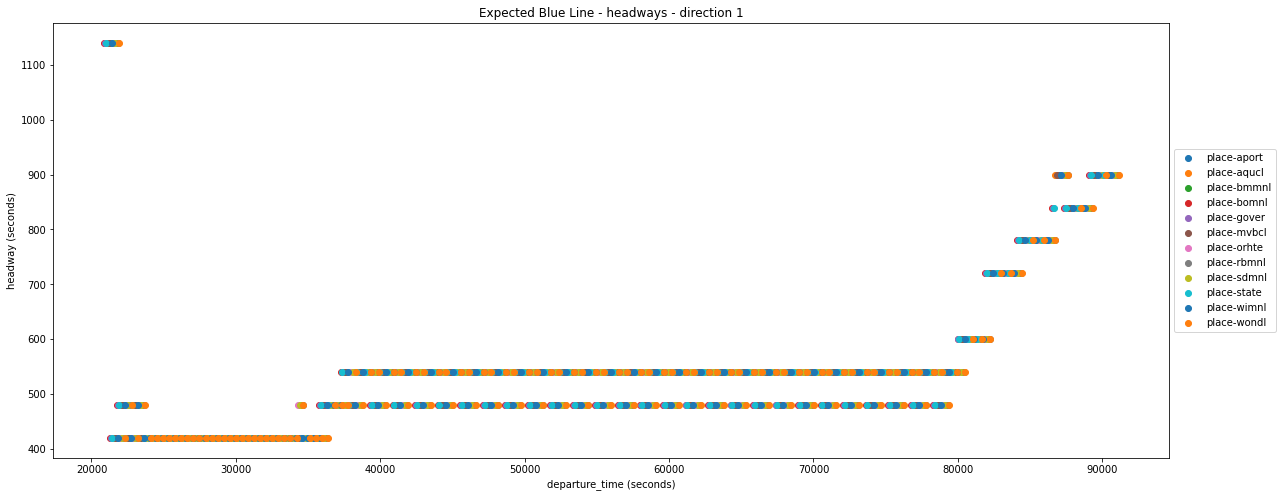

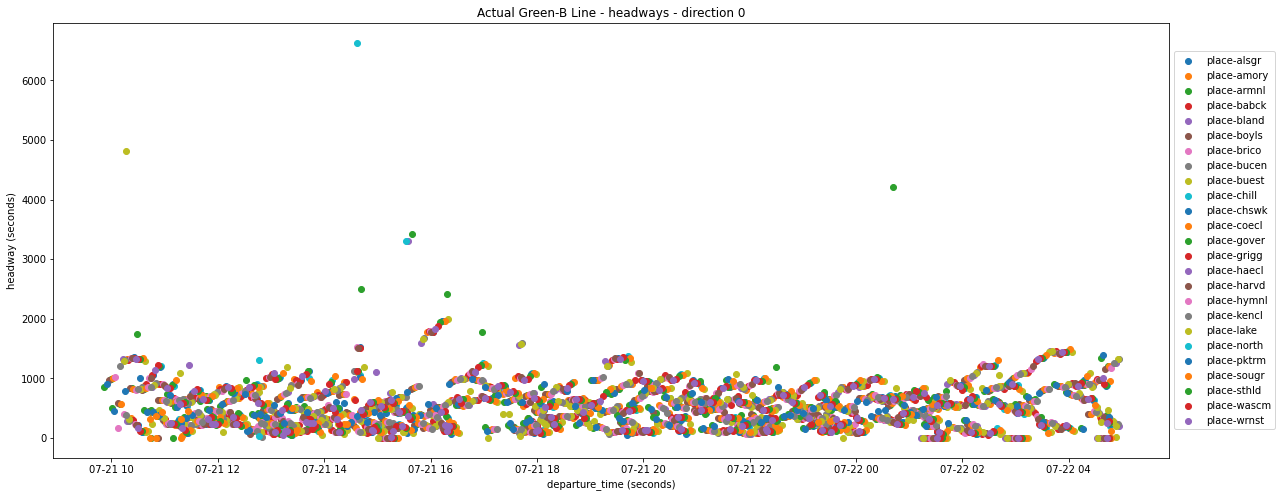

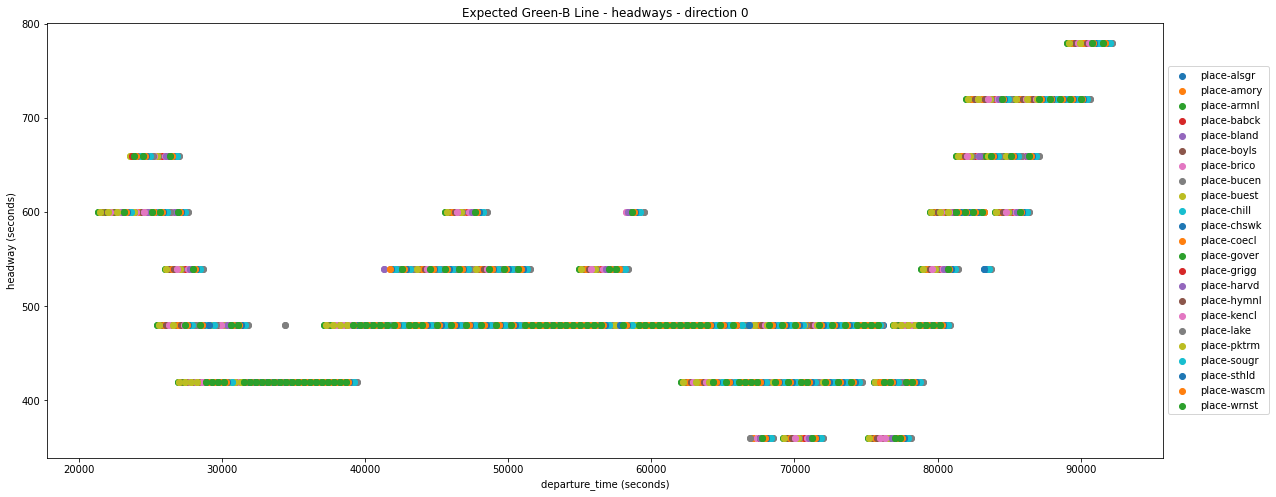

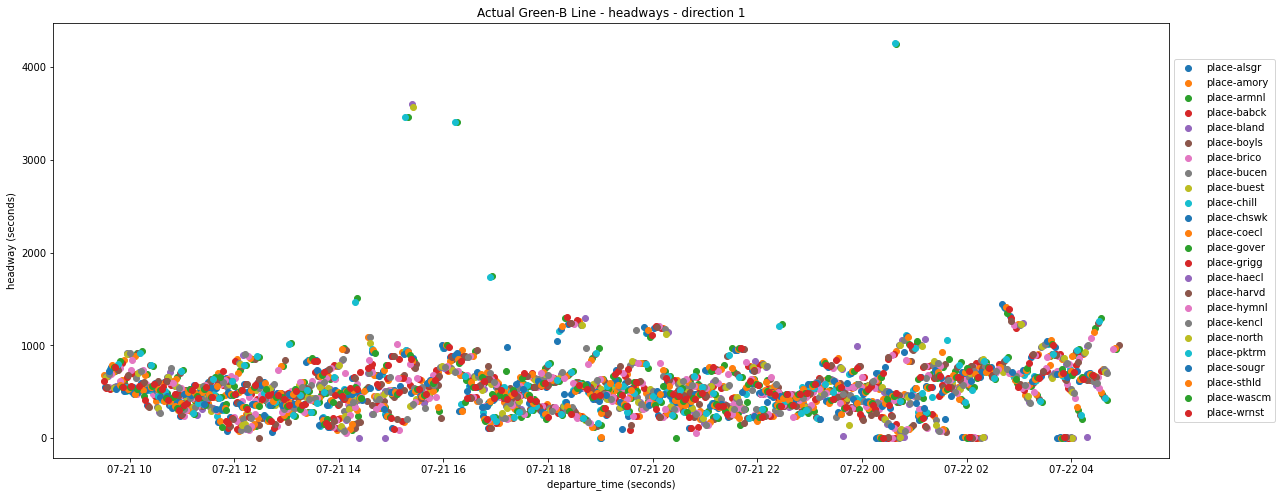

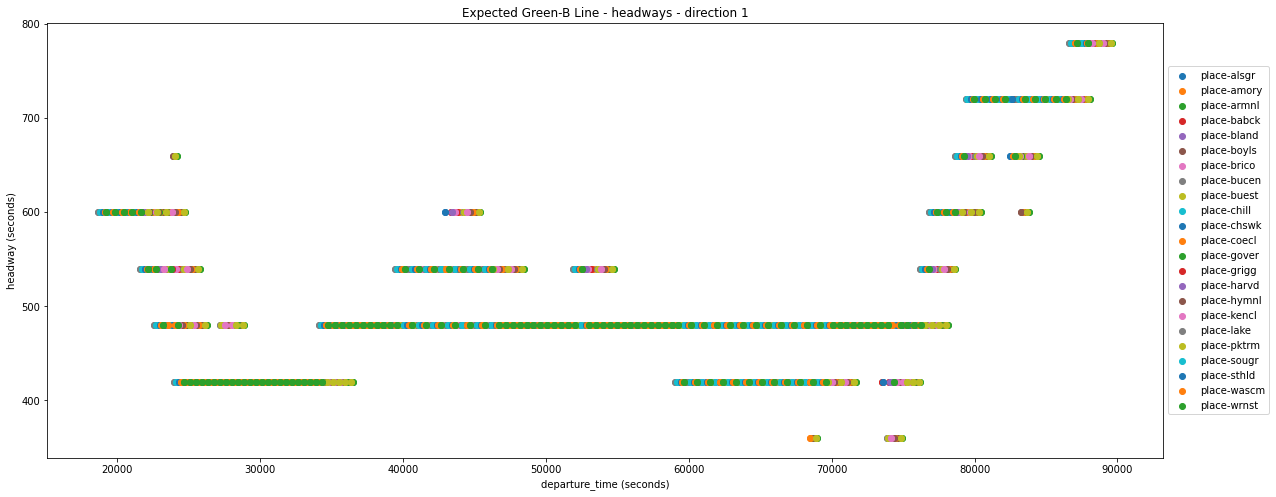

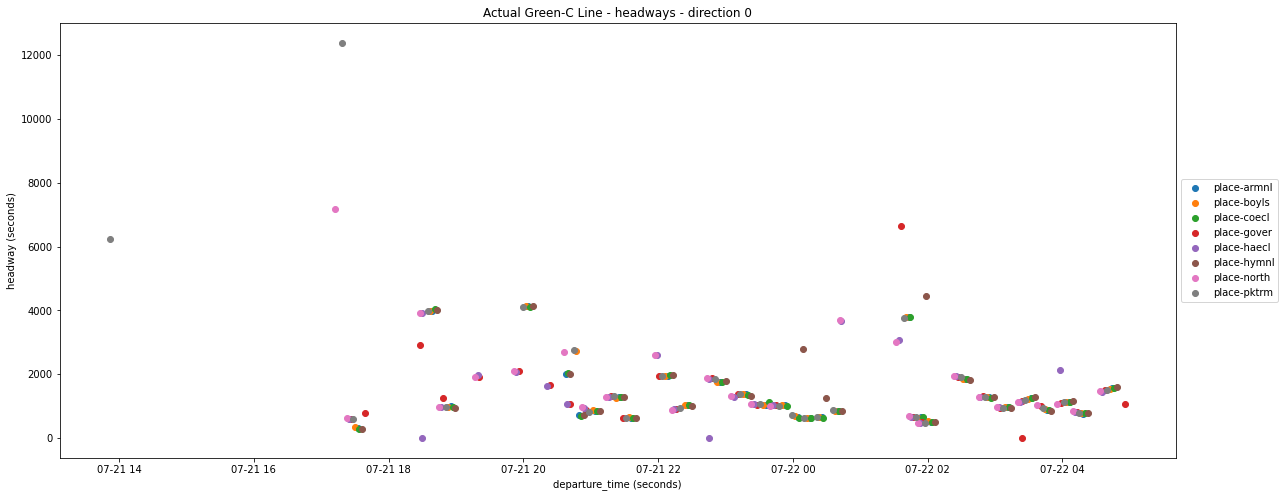

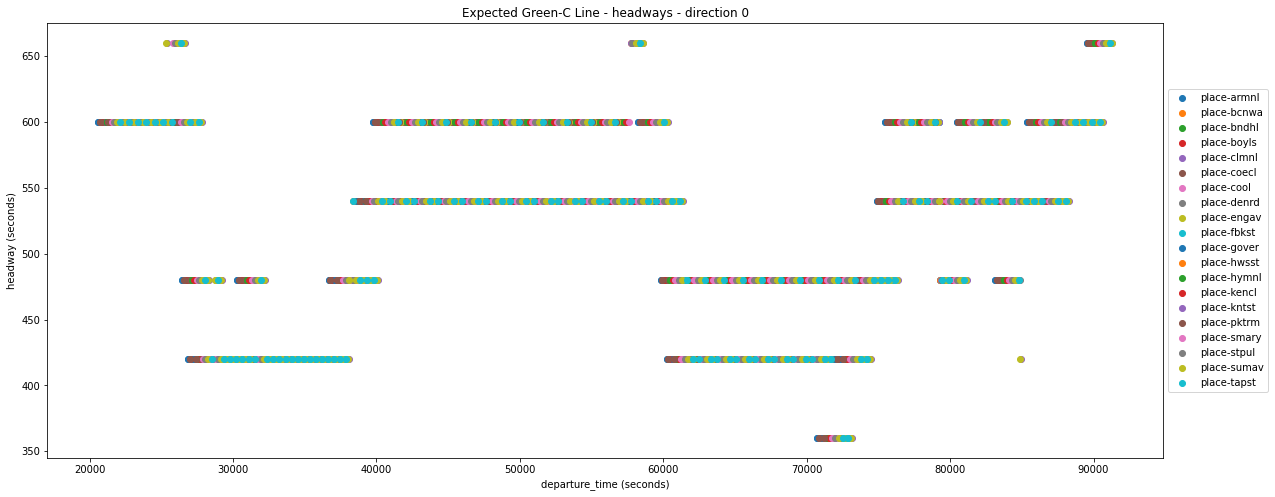

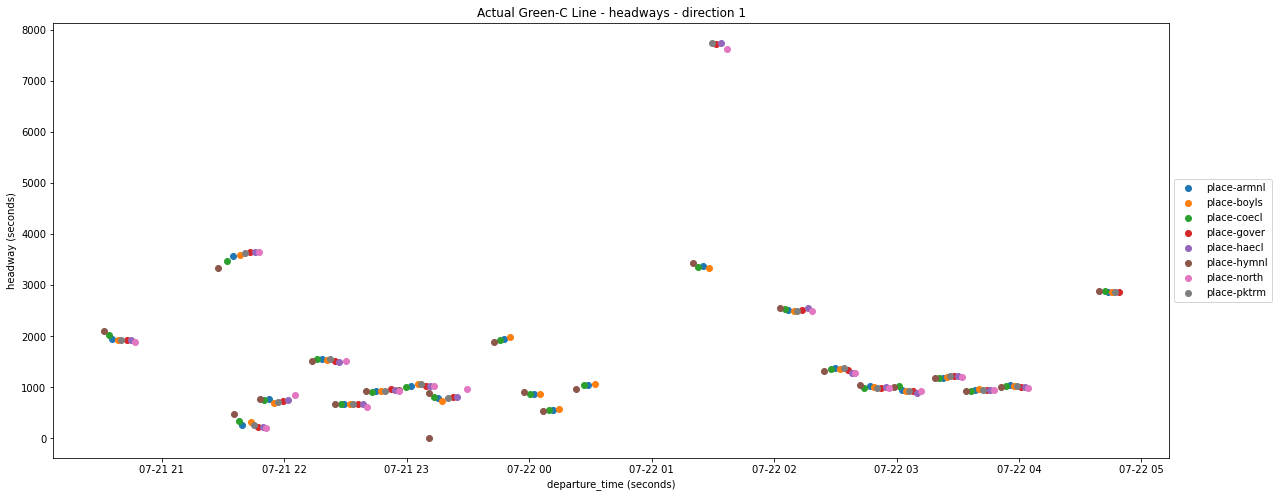

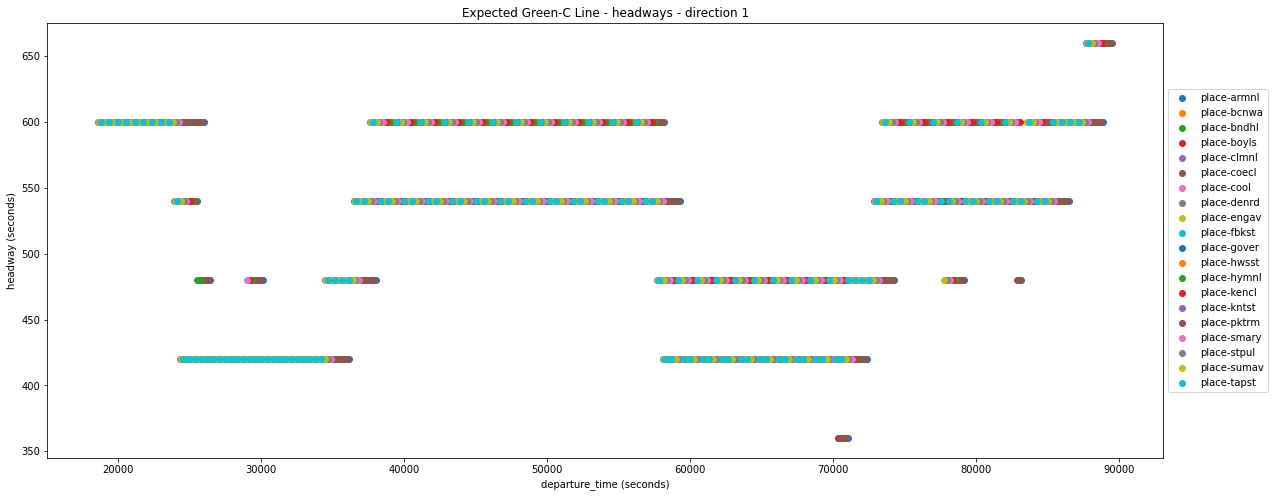

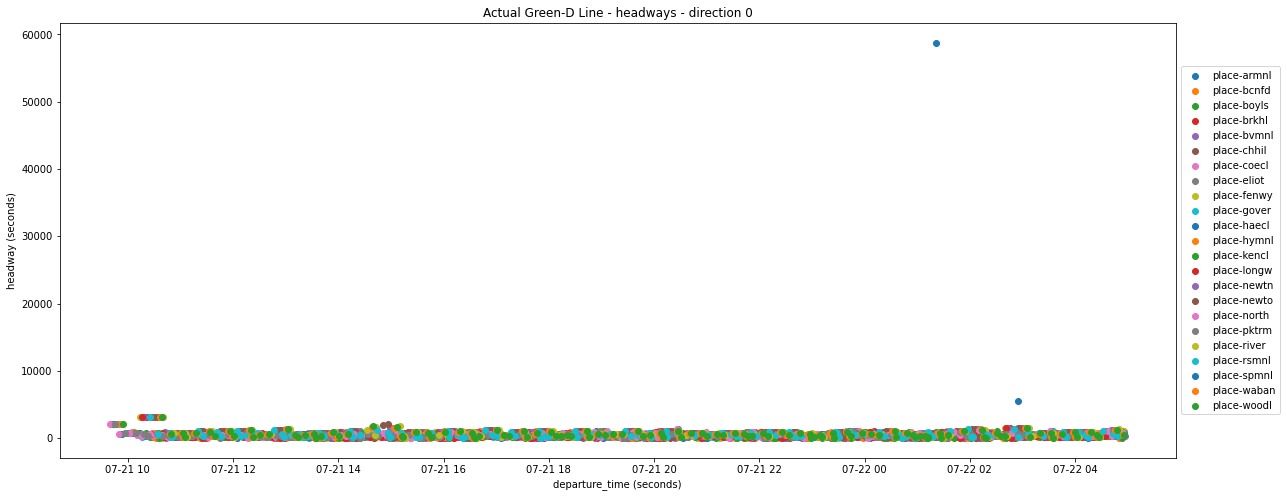

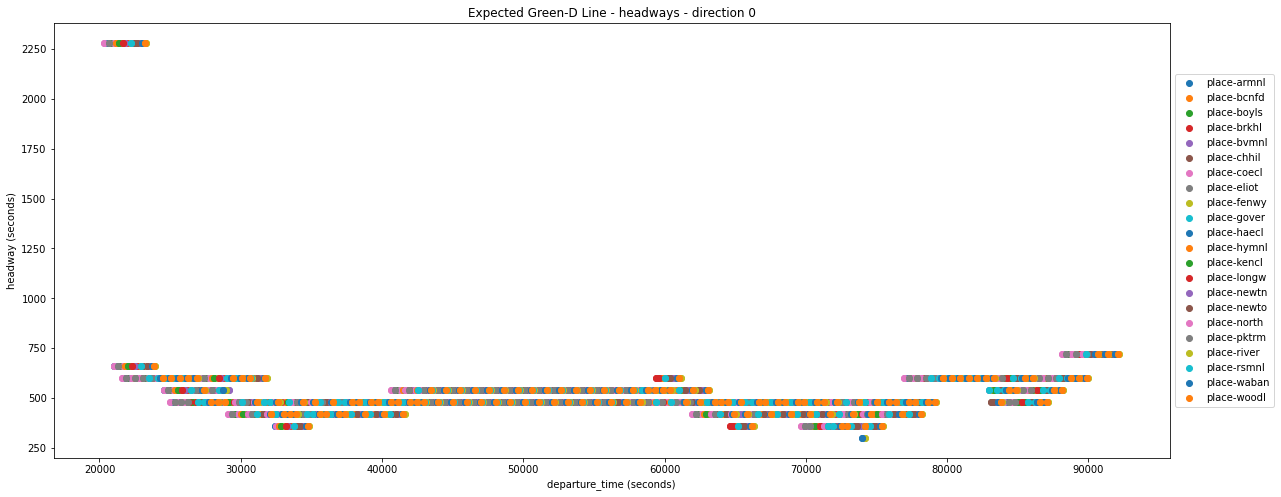

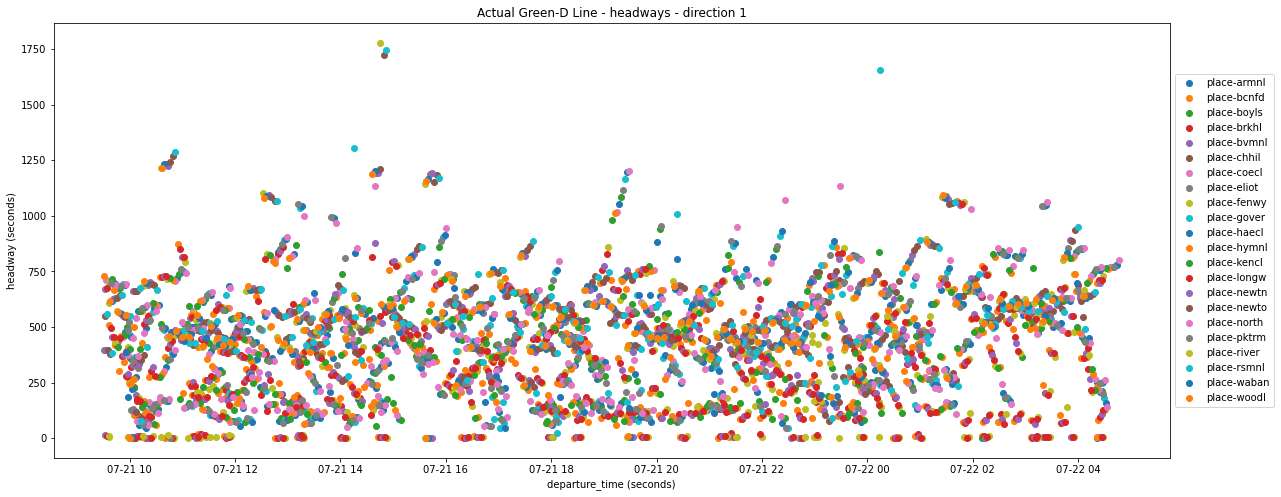

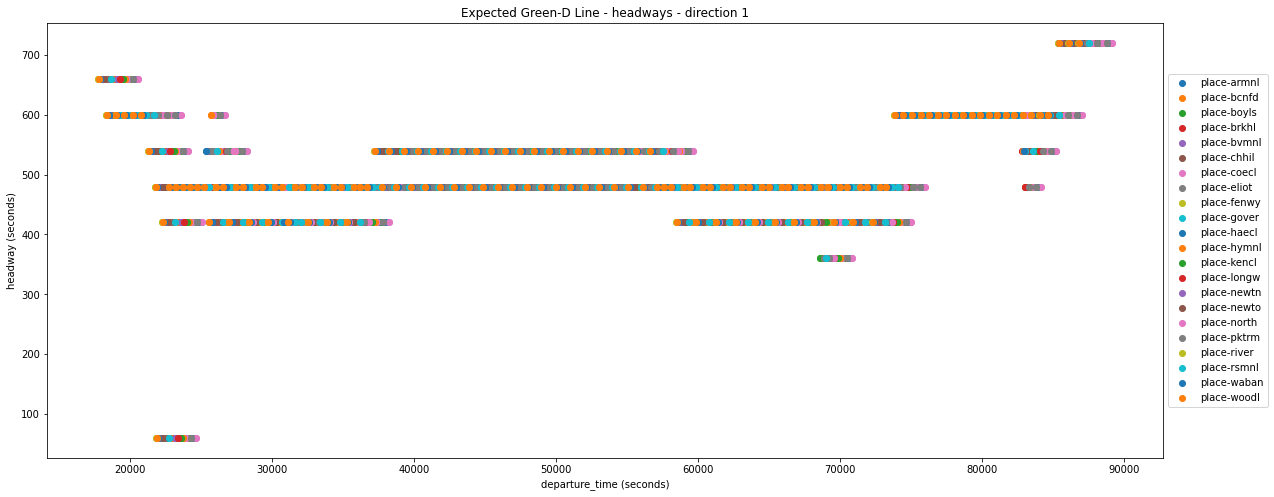

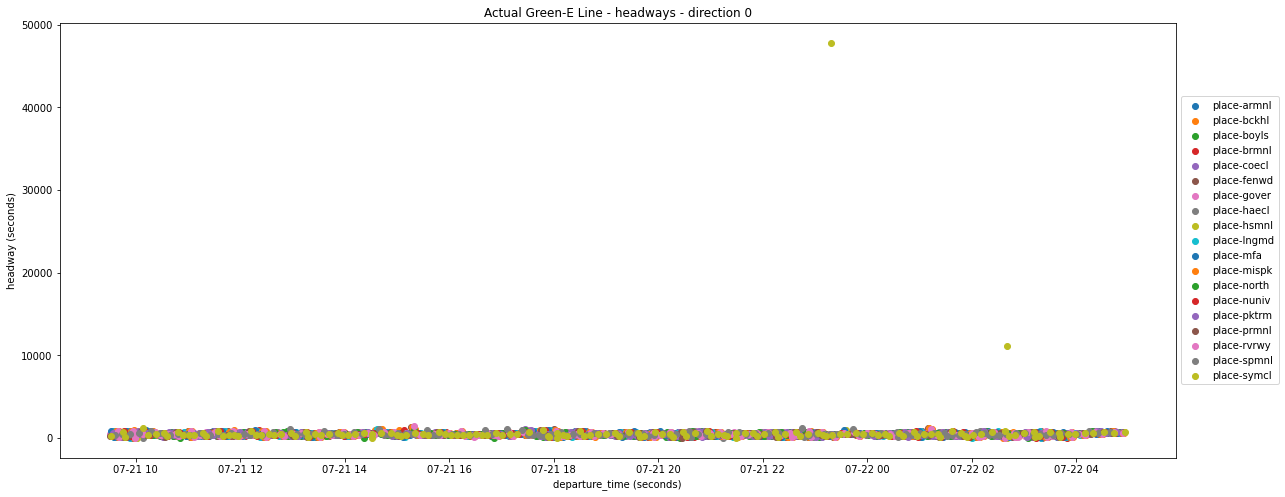

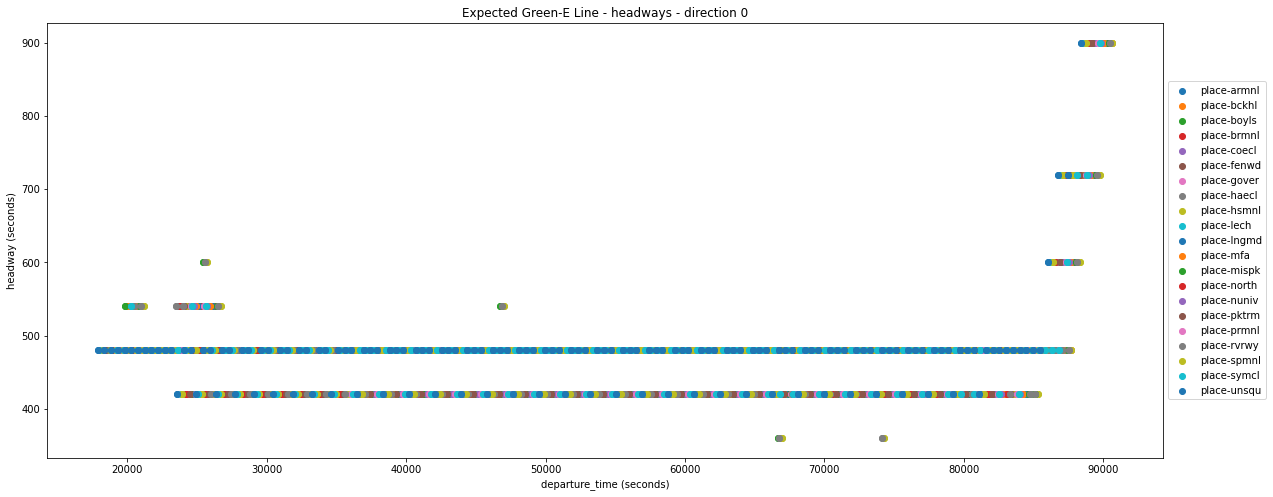

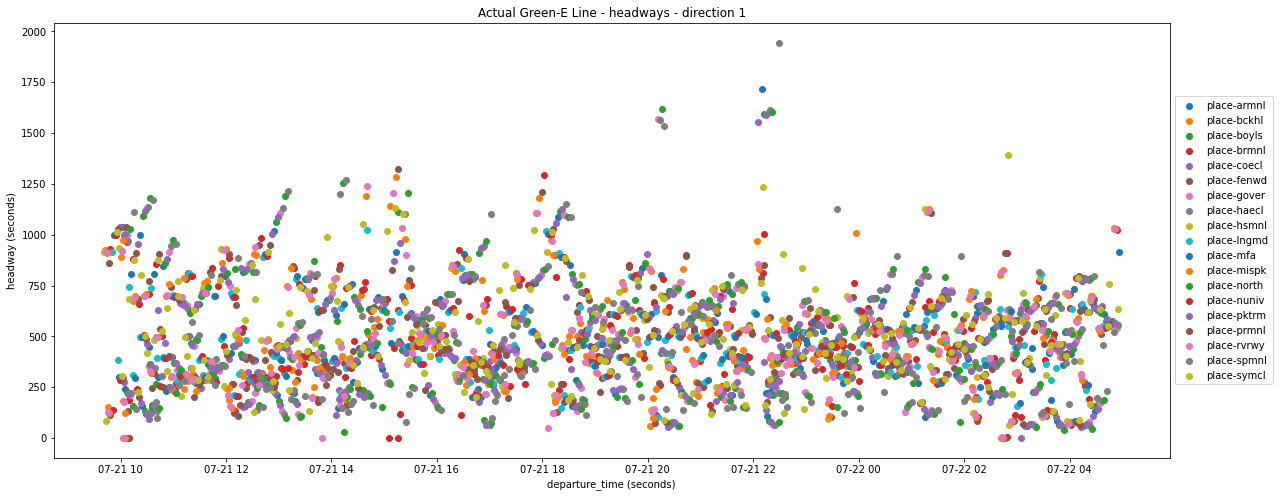

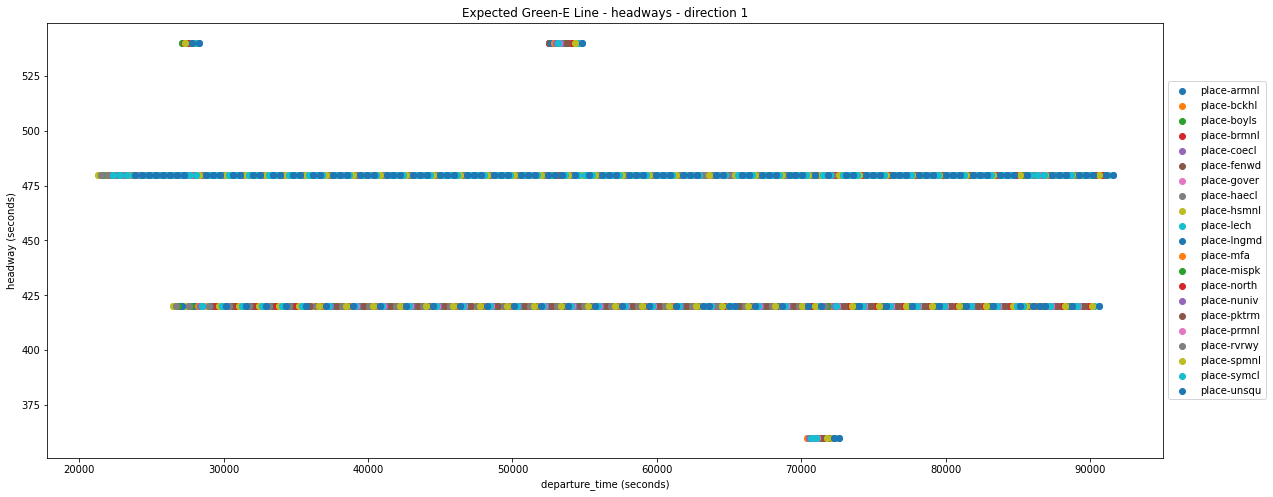

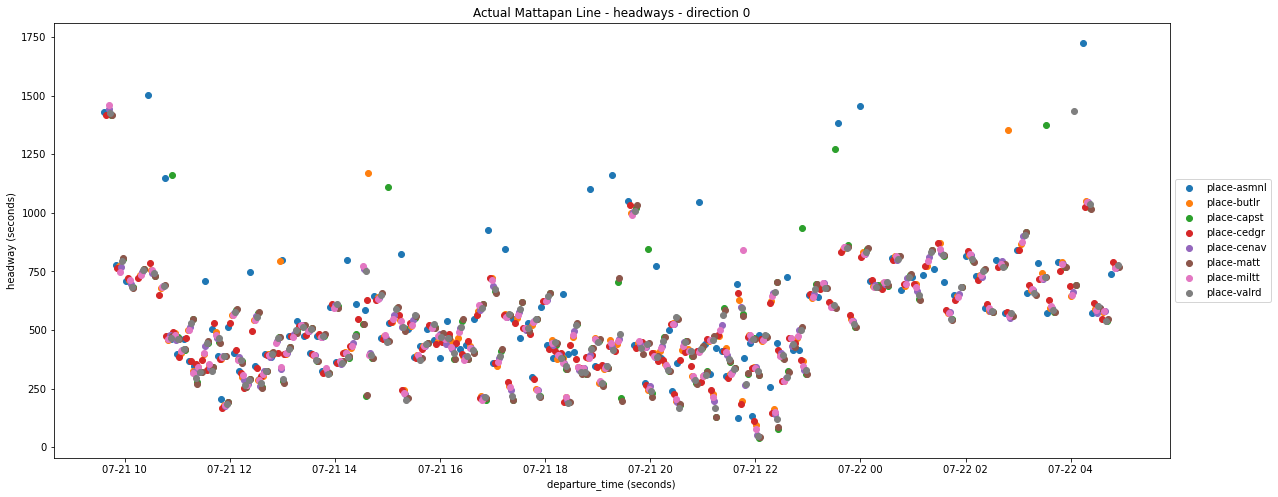

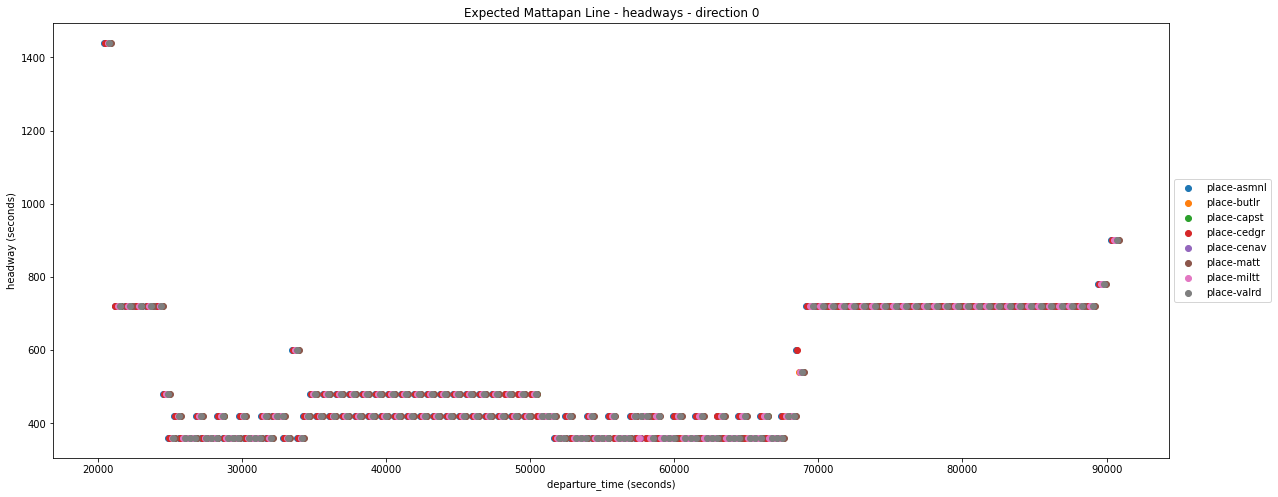

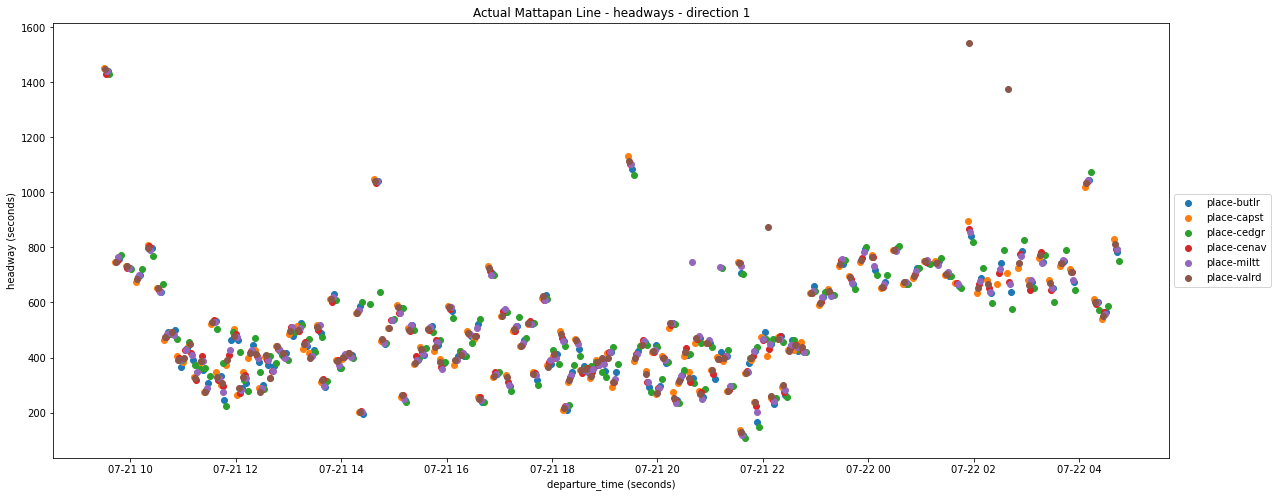

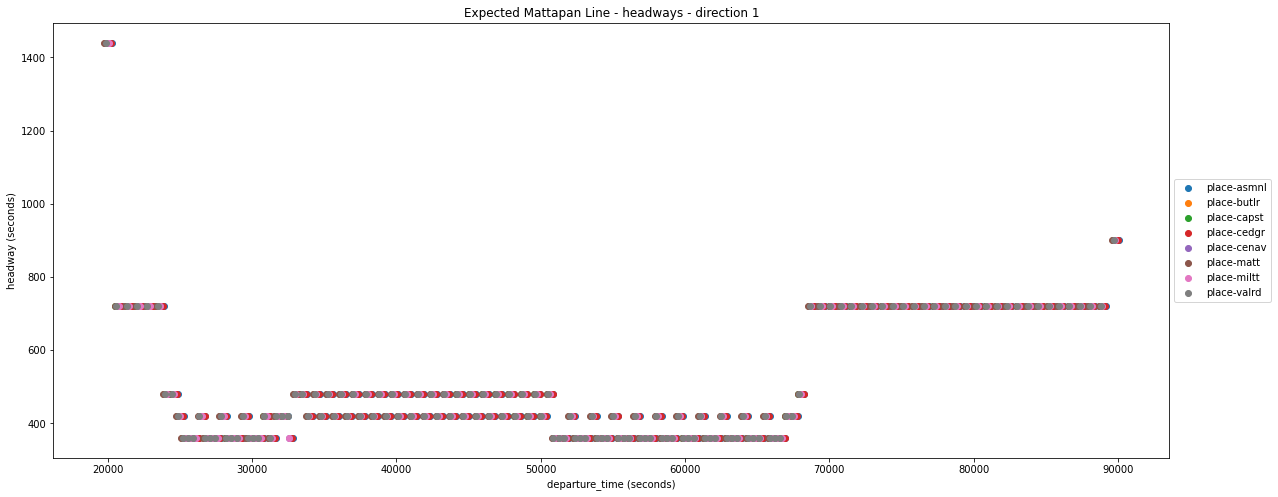

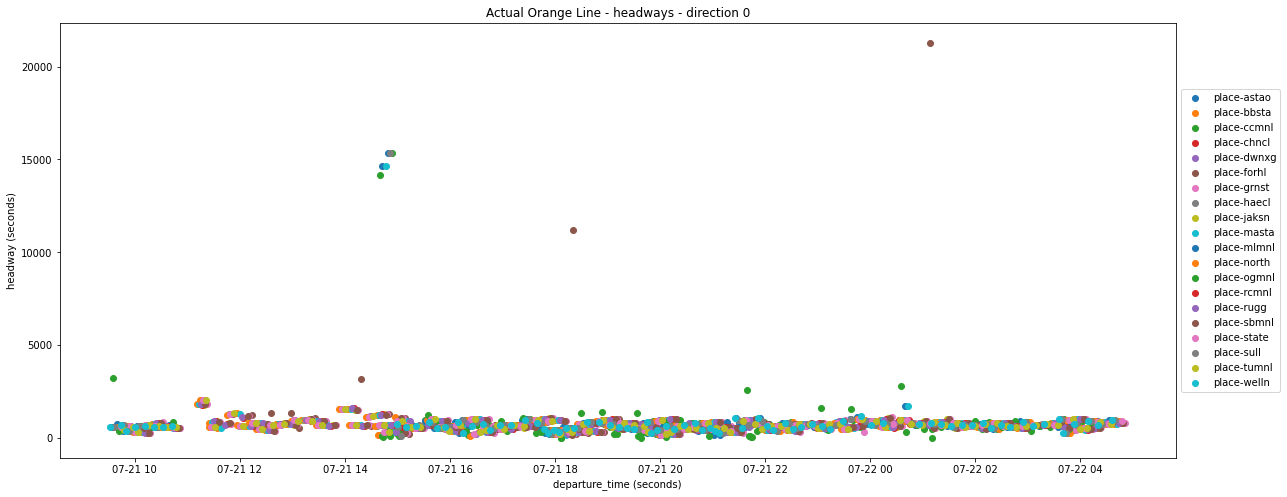

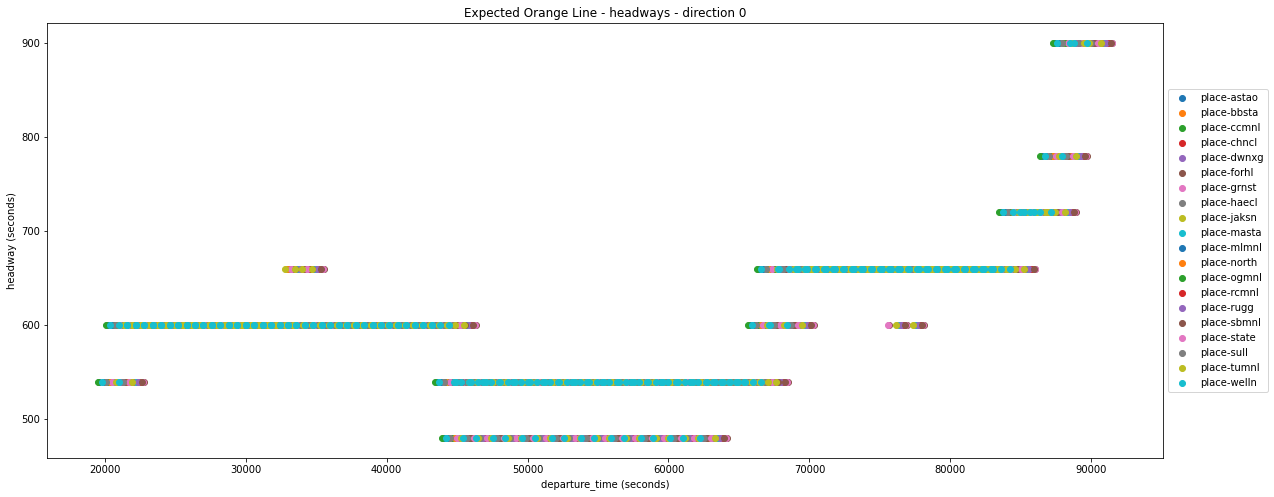

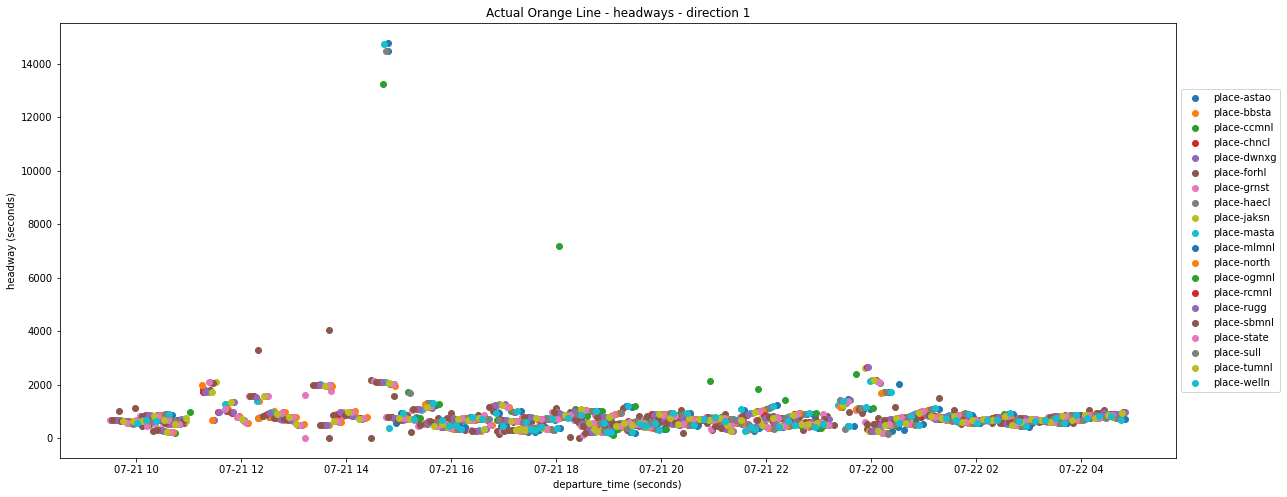

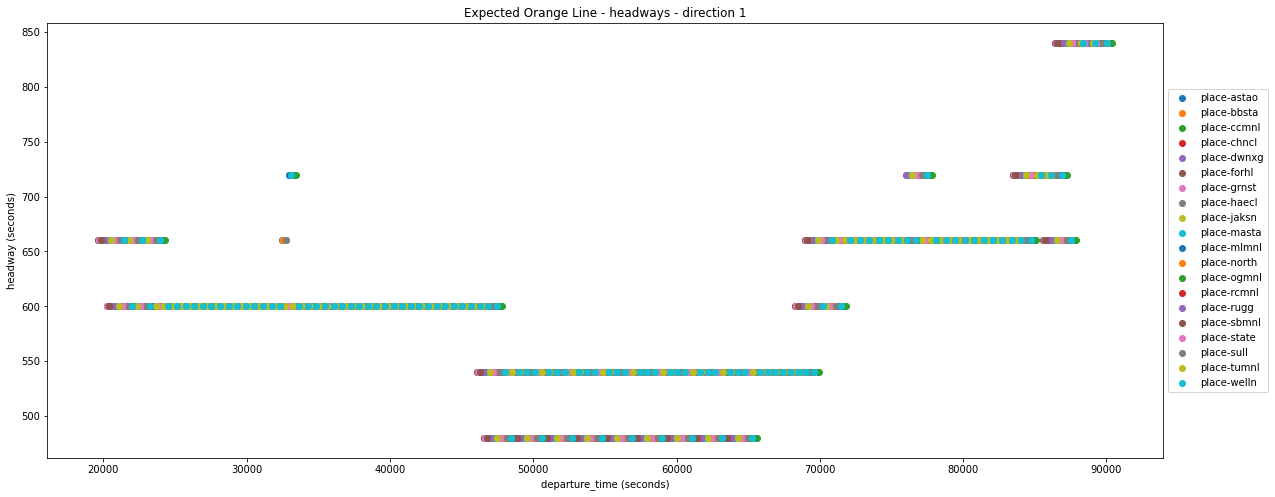

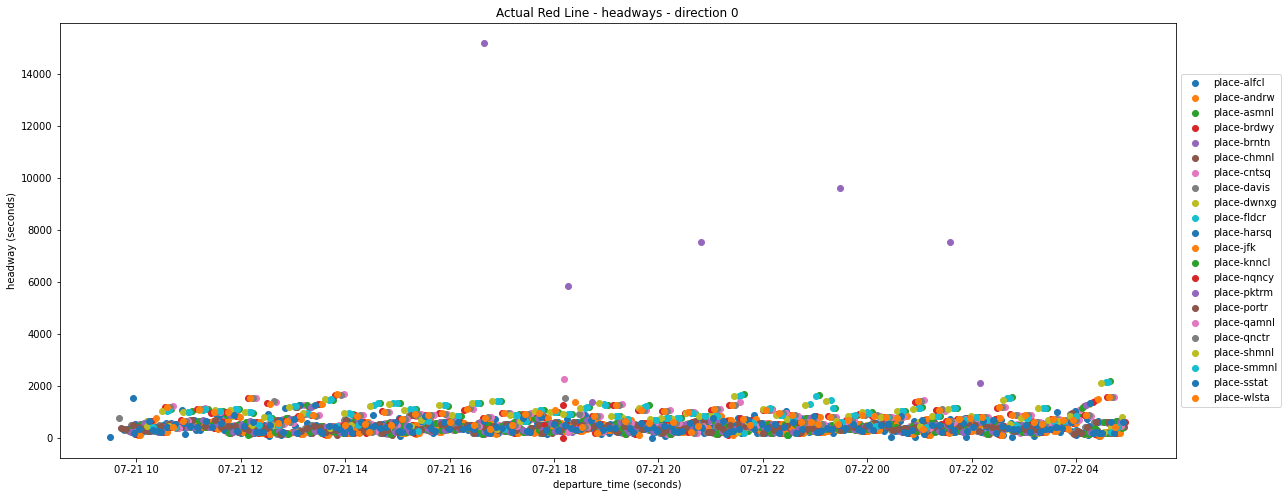

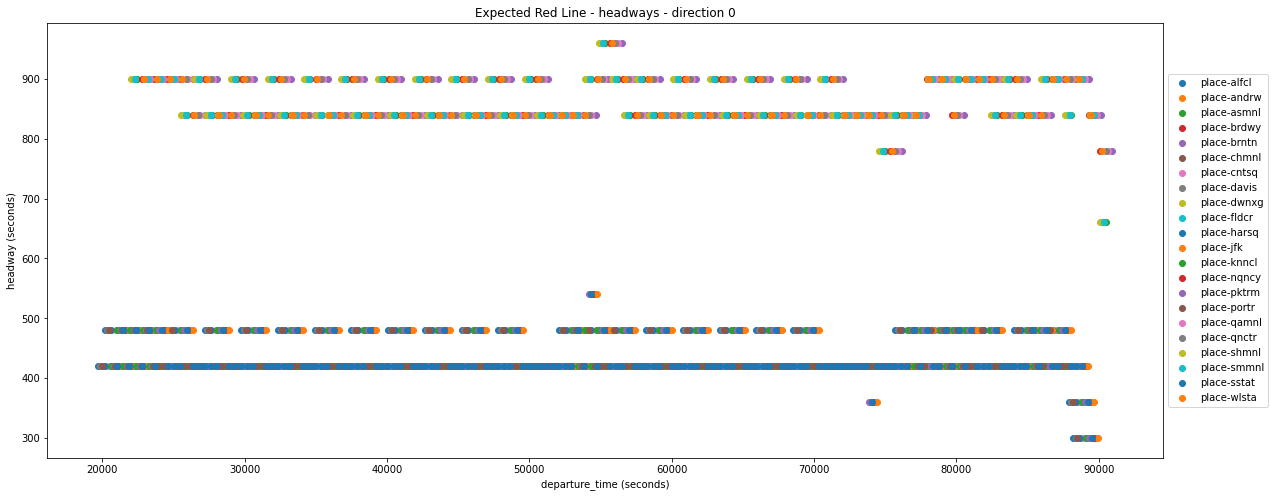

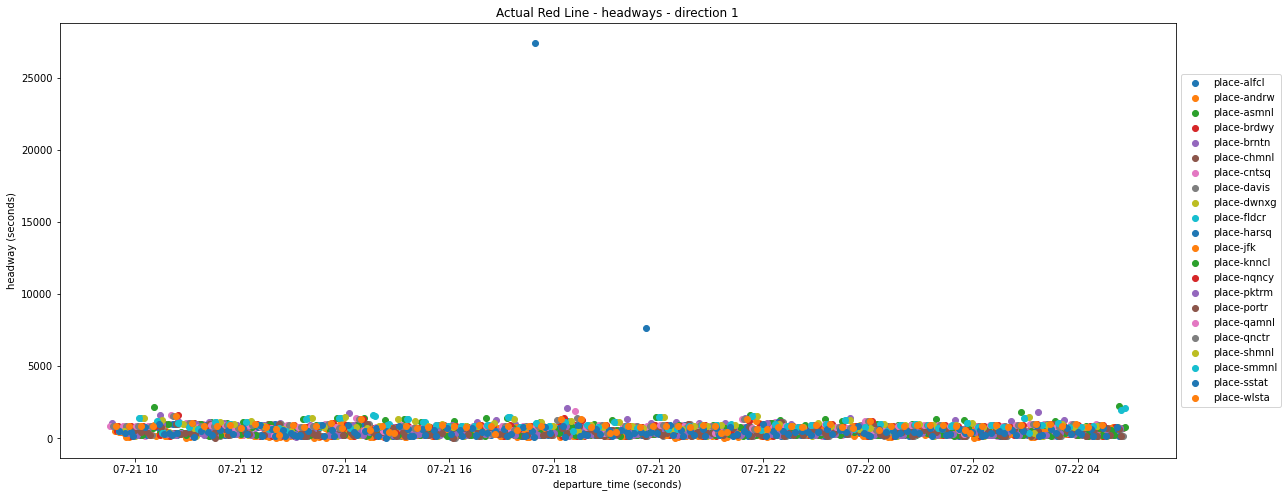

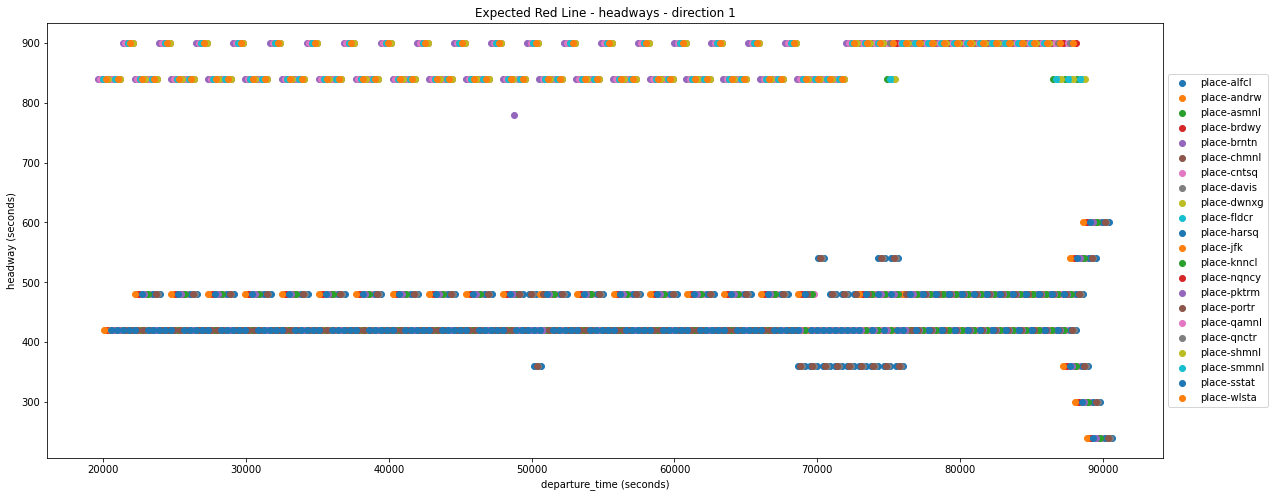

In [11]:


start_time = 1658395804

for route_id in sorted(rt_headways.route_id.unique()):
    route_df = rt_headways[
            (rt_headways.route_id == route_id)
            & (rt_headways.vehicle_timestamp_min > start_time)
            & (rt_headways.vehicle_timestamp_min < start_time + 70000)
            # & (rt_head.head_way < 2000)
        ]
    sch_df = sub_gtfs_headways[
        (sub_gtfs_headways.route_id == route_id)
        & (sub_gtfs_headways.thursday == 1)
    ]
    for direction_id in (0,1):
        t_df = route_df[
            (route_df.direction_id == direction_id)
        ]
        t2_df = sch_df[
            (sch_df.direction_id == direction_id)
        ]
        fig, ax = plt.subplots(figsize=(20,8))
        for checkpoint_id in sorted(t_df.parent_station.unique()):
            line_df = t_df[(t_df.parent_station == checkpoint_id)]
            ax.scatter(line_df['dt'], line_df['head_way'], label=checkpoint_id )
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_xlabel('departure_time (seconds)')
        ax.set_ylabel('headway (seconds)')
        ax.set_title(f'Actual {route_id} Line - headways - direction {direction_id}')

        fig, ax = plt.subplots(figsize=(20,8))
        for checkpoint_id in sorted(t2_df.parent_station.unique()):
            line_df = t2_df[(t2_df.parent_station == checkpoint_id)]
            ax.scatter(line_df['departure_time_sec'], line_df['head_way'], label=checkpoint_id )
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_xlabel('departure_time (seconds)')
        ax.set_ylabel('headway (seconds)')
        ax.set_title(f'Expected {route_id} Line - headways - direction {direction_id}')